In [1]:
#Jeg indlæser først modulerne
import re
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean 
import matplotlib.pyplot as plt
from collections import Counter 
from pandarallel import pandarallel
import pandas as pd



In [2]:
#Læser data-filen
df = pd.DataFrame(pd.read_csv("news_sample.csv")) #indsæt her træning

#news_sample.csv
#/Users/Danie/GDS/CSV/995,000_rows.csv

#Vi bruger 'content' kolonnen.
my_cleaning_df = df[["content","id"]].copy()

#Vi bruger 'content' kolonnen.
#my_cleaning_df = df[["content"]].copy()

In [3]:
df.head(3)

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN


In [4]:
my_cleaning_df.head()

,content,id
0,Sometimes the power of Christmas will make you...,141
1,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,256
2,Never Hike Alone: A Friday the 13th Fan Film U...,700
3,"When a rare shark was caught, scientists were ...",768
4,Donald Trump has the unnerving ability to abil...,791


In [7]:
#Gør den raw dataframe 'content' til en string
uncleaned_string = '\n'.join(df["content"].astype(str))

#Gør 'uncleaned_string' til en liste
uncleaned_list=uncleaned_string.split() 
print("antal uncleaned words",len(set(uncleaned_list)))     #Gør listen til et set så gentagne elementer kun optræder 1 gang

antal uncleaned words 30005


In [9]:
#Funktion der gør tekst til lower-case
def all_lower(x):
    x= x.lower()
    return x

#Funktion der fjerner tegn
def remove_special_chars(x):
    import re 
    return re.sub(r"[^a-zA-Z0-9<>]", " ", x)

#Skal vi gøre det her???
#auto_cleaning_df = df[["content"]].copy() #Memory???

#Funktion der erstatter datoer med <DATE>

def sub_dates(x):
    import re 
    sub_dates = re.sub(r'\d{4}[-/]\d{2}[-/]\d{2}|\d{2}[-/]\d{2}[-/]\d{4}', ' <DATE> ', x)
    sub_dates = re.sub(r'\b[a-z]+\s\d{1,2},\s\d{4}\b', '<DATE>', sub_dates)
    sub_dates = re.sub(r'\b\d{1,2}[,]?\s[a-zA-Z]+\s\d{4}\b', '<DATE>', sub_dates)
    return sub_dates

#Definerer variablen 'stopwords' som er et set af alle stopwords importeret fra modulet nltk


In [10]:
# Initialiser pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=4)  #giver os en progress
  # Brug 4 kerner... ændr ved bluescreen

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [14]:
#Funktion til at cleane tekst
def autocleandf(df):
    from cleantext import clean 
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))

    my_cleaning_df['content']=my_cleaning_df['content'].astype(str).fillna("")

    my_cleaning_df['content']=my_cleaning_df['content'].parallel_apply(sub_dates)          #Applyer funktionen 'sub_dates' på 'content' kolonnen
    
    my_cleaning_df['content']=my_cleaning_df['content'].parallel_apply(                    #Applyer clean funktion fra modulet cleantext.
        lambda x: clean(str(x), lower=True, no_urls=True, no_emails=True, no_numbers=True, no_punct=True, no_currency_symbols=True))
    
    my_cleaning_df['content']=my_cleaning_df['content'].parallel_apply(lambda x: word_tokenize(str(x)))  #Applyer word_tokenize funktion fra nltk, som laver det til en liste af strings
    
    exclude_words = {"number", "date", "url", "email", "<", ">"}

    my_cleaning_df['content']=my_cleaning_df['content'].parallel_apply(
        lambda x: [word for word in x if word.lower() not in exclude_words])
    
    my_cleaning_df['content']=my_cleaning_df['content'].parallel_apply(
        lambda x: [word for word in x if word.lower() not in stop_words])

#OBS DEN SIDSTE ER SOM FORMAT LISTE OG NESTED FOR LOOP
#STEMMNING ER LÆNGERE NEDE I DOKUMENTET. DENNE ER LAVET RIGTIG PÅ SARAHS
autocleandf(df)

In [ ]:
#Stemming med modulet nltk


def stemming():
    from nltk.stem import PorterStemmer
    ps=PorterStemmer()
    my_cleaning_df['content'] = my_cleaning_df['content'].astype(str)  #Konvertere liste til string
    my_cleaning_df['content']=my_cleaning_df['content'].parallel_apply(lambda x: ps.stem(x))
stemming()


In [27]:
my_cleaning_df.head()

,content,id
0,"['sometimes', 'power', 'christmas', 'make', 'w...",141
1,"['awakening', 'strands', 'dna', 'reconnecting'...",256
2,"['never', 'hike', 'alone', 'friday', '13th', '...",700
3,"['rare', 'shark', 'caught', 'scientists', 'lef...",768
4,"['donald', 'trump', 'unnerving', 'ability', 'a...",791


In [10]:
# Brug map til at opdatere content baseret på id
df['content'] = df['id'].map(my_cleaning_df.set_index('id')['content'])


In [ ]:
#my_cleaning_df.to_csv("cleaneddf.csv", index=False)

In [12]:
df.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,"[sometimes, power, christmas, make, wild, wond...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,"[awakening, strands, dna, reconnecting, movie,...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,"[never, hike, alone, friday, 13th, fan, film, ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"[rare, shark, caught, scientists, left, blunde...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,"[donald, trump, unnerving, ability, ability, c...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


In [13]:
#auto_cleaning_df.to_csv("renset.csv", index=False)

In [14]:
#Gør dataframen 'filtered_tokens' til en string

cleaned_string = ' '.join([' '.join(words) for words in my_cleaning_df['content']]) 

#Gør 'cleaned_string' til en liste
cleaned_list = cleaned_string.split() 

#Gør den raw dataframe 'content' til en string
#uncleaned_string = '\n'.join(df["content"].astype(str))

#Gør 'uncleaned_string' til en liste
#uncleaned_list=uncleaned_string.split() 
#print("antal uncleaned words",len(set(uncleaned_list)))     #Gør listen til et set så gentagne elementer kun optræder 1 gang

#Counter tæller antal gange hvert ord optræder
cleaned_antal_ord=Counter(cleaned_list)
     
print("Total wordcount after cleaning:",len(cleaned_antal_ord))

print("Procentsvis ændring:", (len(cleaned_antal_ord)/6129708)*100 )

#antal uncleaned words 6129708

Total wordcount after cleaning: 16482
Procentsvis ændring: 0.2688871965842418


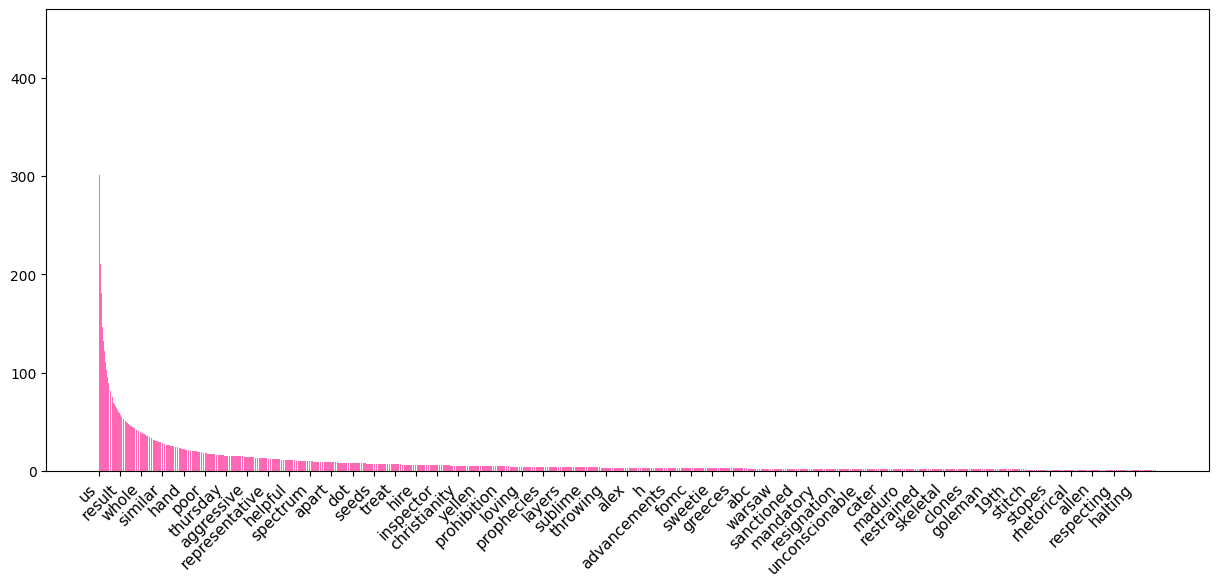

In [15]:
hypiggeste_ord = cleaned_antal_ord.most_common(10000)   #De 10000 mest hyppige ord i 'ord_antal', laves til en liste mad tupler, 
                                                        #bestående af ord og ordet's hyppighed

ord = [ord for ord, tælling in hypiggeste_ord]          #Laver en liste med ordene fra 'hypiggeste_ord'. 
                                                        #Her itereres gennem hver tuple og udtrækkes ordet.
antal = [tælling for ord, tælling in hypiggeste_ord]    #Laver en liste med antal forekomster fra 'hypiggeste_ord'. 
                                                        #Her itereres gennem hver tuple og udtrækkes antal forekomster.
#Plottet
plt.figure(figsize=(15, 6))                             #Figurens højde og bredde
plt.bar(ord, antal, color = "hotpink")                  #'ord' og 'antal' sættes på x- og y-aksen i plottet
#plt.xticks(rotation=45, ha='right', fontsize=11)   
plt.xticks(range(0, len(ord), 200), ord[::200], rotation=45, ha='right', fontsize=11)
#Teksten på x-aksen roteres og tekststørrelsen vælges
plt.show() 

In [17]:
# Brug map til at opdatere content baseret på id
df['content'] = df['id'].map(my_cleaning_df.set_index('id')['content'])

In [18]:
df.head(5)

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,"[sometimes, power, christmas, make, wild, wond...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,"[awakening, strands, dna, reconnecting, movie,...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,"[never, hike, alone, friday, 13th, fan, film, ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"[rare, shark, caught, scientists, left, blunde...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,"[donald, trump, unnerving, ability, ability, c...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


In [19]:
category_mapping = {
    "fake": "Fake News",
    "satire": "Fake Fake",
    "bias": "Fake News",
    "conspiracy": "Fake News",
    "junksci": "Fake News",
    "hate": "Reliable News",
    "clickbait": "Not Fake",
    "unreliable": "Not News",
    "political": "Reliable News", #SKAL VI OMITTE?
    "reliable": "Reliable News"  
}

# Apply the mapping
df['broad_category'] = df['type'].map(category_mapping)

# Check the result to make sure mapping is performed correctly
df[['broad_category', 'type']].head(10)

,broad_category,type
0,Not News,unreliable
1,Fake News,fake
2,Not News,unreliable
3,Not News,unreliable
4,Not Fake,clickbait
5,Not News,unreliable
6,Fake News,conspiracy
7,Fake News,fake
8,Fake News,fake
9,Fake News,conspiracy


In [20]:
df.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,broad_category
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,"[sometimes, power, christmas, make, wild, wond...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN,Not News
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,"[awakening, strands, dna, reconnecting, movie,...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN,Fake News
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,"[never, hike, alone, friday, 13th, fan, film, ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN,Not News
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"[rare, shark, caught, scientists, left, blunde...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN,Not News
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,"[donald, trump, unnerving, ability, ability, c...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN,Not Fake


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [22]:
vectorizer=CountVectorizer(max_features=10000)
x=vectorizer.fit_transform(df['stemmed_text'])
y=df['broad_category']

KeyError: 'stemmed_text'